<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/06_Combine_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring and combining HTR3A protein target activity data from ExcapeDB and DTC databases. 

# Scope of the tutorial
*   Source of HTR3A drug target binding data came from ExcapeDB and Drug Target Commons (DTC)
*   AMPL will be used to accomplish the following steps: 
  *   Standardize SMILES strings
  *   Clean the data (look for duplicates, average the assay data, cluster the compounds etc.)
  *   Merge the datasets
  *   Carry out some Exploratory Data Analysis (Chemical space exploration; PCA etc.) 
  *   Save the final dataset for modeling

# Time to run the notebook on COLAB-Pro: ~ 3 minutes

# Protein target (HTR3A) information

The HTR3A target binding data was downloaded from the following two databases: 
* ExcapeDB (https://solr.ideaconsult.net/search/excape/)
  * Please refer to the ExCAPE-DB publication, https://pubmed.ncbi.nlm.nih.gov/28316655/, for details about the database 

* Drug Target Commons (https://drugtargetcommons.fimm.fi/)
  * Please refer to the DTC publication, https://pubmed.ncbi.nlm.nih.gov/29276046/, for details about the database. 

Here are some details about HTR3A gene (taken from RefSeq NCBI)


*   Proteins belongs to GPCR superfamily
*   HTR3a is a receptor for Serotonin, a biogenic hormone that functions as a neurotransmitter
*   HTR3A (also the name of the gene) encodes the subunit of the type 3 receptor for neurotransmitter 
*   Herteromeric combination of subunit A and B (HTR3B) is needed for full function. 
*   Different alternately spliced transcript variant forms for this gene are available.  

## Additional information about HTR3A gene:

**Gene location:** Chromosome 11
**Exon count:** 10

mRNA and protein information for its three transcripts:

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 

# Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

In [1]:
!date # starting time

Fri Sep 17 13:14:04 UTC 2021


## Install AMPL

In [ ]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh'

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor HTR3A

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import os
import requests

In [5]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

In [6]:
from matplotlib_venn import venn2
import getpass, os
import pandas as pd
import matplotlib.pyplot as plt
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.chem_diversity as cd

## Select a target to work with 
### (e.g. PDE2A, KCNH2, SCNA5)

In [7]:
target_name='HTR3A'

In [8]:
import io

url1='https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/HTR3A_dtc_smiles_curated.csv'
url2='https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/HTR3A_excape_curated.csv'

download = requests.get(url2).content

# Reading the downloaded content and turning it into a pandas dataframe
d2_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

download = requests.get(url1).content

# Reading the downloaded content and turning it into a pandas dataframe
d1_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [9]:
d1a_df=d1_df.drop(columns=['relation'])
d1a_df.rename( columns={ "base_rdkit_smiles" : "rdkit_smiles" }, inplace=True)
print(d1a_df.columns)

Index(['compound_id', 'rdkit_smiles', 'PIC50', 'active'], dtype='object')


In [10]:
d2a_df=d2_df.drop(columns=['Original_Entry_ID', 'Entrez_ID','PXC50', 'DB', 
                           'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
                           'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate',
                           'Ortholog_Group', 'InChI', 'SMILES'])
d2a_df.rename( columns={ "Activity_Flag" : "active", "VALUE_NUM_mean": "PXC50" }, 
              inplace=True)


print(d2a_df.columns)

Index(['compound_id', 'active', 'rdkit_smiles', 'PXC50'], dtype='object')


In [11]:
d1a_df.rename( columns={"PIC50" : "PXC50"}, inplace = True)

In [12]:
d2a_df

,compound_id,active,rdkit_smiles,PXC50
0,ABIDZKZAFOTHFB-CCUGXXBONA-N,A,C[C@H]1COC[C@H](C)N1c1nc2c(C(=O)N[C@@H]3CN4CCC...,8.170000
1,ABSDJNLAUZQHJY-UHFFFAOYNA-N,A,COc1cccc(Sc2ccccc2N2CCNCC2)c1,7.210000
2,ACKJXXOVSOCBPX-PHLAQJRANA-N,A,Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCCCCCCNc1c2...,8.250905
3,ADYMTDFOOCWUHC-UHFFFAOYNA-N,A,c1ccc(CCn2c(N3CCNCC3)nc3ccccc32)cc1,8.130000
4,AFLJKKMTBWNZFE-KAASGWQYNA-N,A,O=C(N[C@H]1CN2CCC1CC2)c1ccc2ccsc2c1,6.760000
...,...,...,...,...
591,ZTOYBNWVJQYBOX-KKBRQIQINA-N,A,CN1[C@H]2CCC[C@@H]1C[C@@H](NC(=O)c1cccc3oc(N4C...,7.140000
592,ZUFRPGFBOPXENO-UHFFFAOYNA-N,A,CC1CCC2=NC(=CCCCN3CCN(c4ccc5ccccc5n4)CC3)N(N)C...,7.320000
593,ZXDOWRQWHIUDFJ-ALLFDXPCNA-N,A,CN1[C@H]2CCC[C@@H]1CC(NC(=O)c1cccc3nc(-c4ccccc...,7.393620
594,ZXDOWRQWHIUDFJ-JJVVVXOKNA-N,A,CN1[C@H]2CCC[C@@H]1C[C@@H](NC(=O)c1cccc3nc(-c4...,7.390000


In [13]:
d1a_df

,compound_id,rdkit_smiles,PXC50,active
0,WLYLIKBNGQZDFH-UHFFFAOYSA-N,O=C(NCCCN1CCOCC1)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(...,5.886057,0
1,PNHTUMMCJLWVTR-UHFFFAOYSA-N,COc1ccc(-c2cc(NC(=O)CCCCN3CCCOCC3)n[nH]2)cc1,4.522879,0
2,PYCJRTFNOGPLEL-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(Cl)ccc...,7.000000,1
3,MMIPHEFKLSFNNB-MWGLOKQDSA-L,COc1ccc(C[N+]23CCC4C5C6C(CC42)C(=CCOC6N2c4cccc...,4.511439,0
4,PWVBQEUMVVPFJT-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(F)ccc2...,7.000000,1
...,...,...,...,...
165,CZWQBSKNHUVZLI-UHFFFAOYSA-N,c1ccc(Cc2ncc3c(n2)CCNCC3)cc1,5.638272,0
166,QZHACJCMCCGZRU-UHFFFAOYSA-N,Cc1cc(N2CCN(CCCCc3nc4c(c(=O)n3N)CCCC4)CC2)nc2c...,7.228413,1
167,FALASSBEVXPICK-UHFFFAOYSA-N,CCCn1c(=O)[nH]c2cc(C(=O)NCCN3CCCCC3)ccc2c1=O,5.657577,0
168,YMGCQAHDDYCKLB-UHFFFAOYSA-N,CC1CCCCN1CCCNC(=O)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c...,4.935542,0


Text(0.5, 1.0, 'HTR3A')

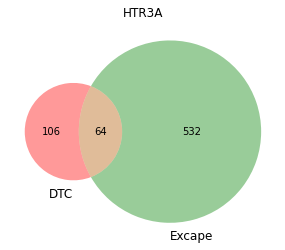

In [14]:
# Plot venn3 distribution 
d1_s = d1a_df['rdkit_smiles'].tolist()
d2_s = d2a_df['rdkit_smiles'].tolist()
#display(d1_s)
#display(d2_s)
dlst = [set(d1_s),set(d2_s)]

fig = plt.figure()
venn2(dlst, ('DTC', 'Excape'))
plt.title(target_name)
#fig.savefig('./plots/'+target_name+'_union_venn.png')
#fig

## Combine d1a_df and d2a_df dataframes 

In [15]:
comb_df=pd.concat([d1a_df, d2a_df])

In [16]:
comb_df.columns

Index(['compound_id', 'rdkit_smiles', 'PXC50', 'active'], dtype='object')

In [17]:
comb_df.head(5)

,compound_id,rdkit_smiles,PXC50,active
0,WLYLIKBNGQZDFH-UHFFFAOYSA-N,O=C(NCCCN1CCOCC1)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(...,5.886057,0
1,PNHTUMMCJLWVTR-UHFFFAOYSA-N,COc1ccc(-c2cc(NC(=O)CCCCN3CCCOCC3)n[nH]2)cc1,4.522879,0
2,PYCJRTFNOGPLEL-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(Cl)ccc...,7.000000,1
3,MMIPHEFKLSFNNB-MWGLOKQDSA-L,COc1ccc(C[N+]23CCC4C5C6C(CC42)C(=CCOC6N2c4cccc...,4.511439,0
4,PWVBQEUMVVPFJT-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(F)ccc2...,7.000000,1


In [18]:
ofile=target_name+'_combine_curated.csv'

# column: Response values column
column = 'PXC50'

# tolerance: Percentage of individual respsonse values allowed to different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       comb_df, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (766, 8)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, PXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (702, 8)
New column created with averaged values:  VALUE_NUM_mean


Post-processing dataset

Total Number of results = 702
dataset mean = 6.738187704369989 NM
dataset stdev = 1.5379201957059792 NM
dataset max = 10.5 NM
dataset min = 3.06 NM



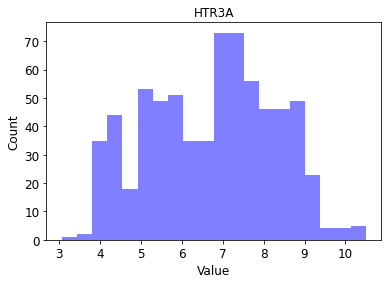

In [19]:
# Define the outcome column as PXC50
column = 'PXC50'

# # of 'bins' for the histogram
num_bins = 20

title = target_name

units = 'NM'

filepath = ""

data=curated_df

curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [20]:
feat_type='ECFP'
dist_metric='tanimoto'
union_s = curated_df['rdkit_smiles'].tolist()

smiles_lst1 = d1a_df['rdkit_smiles'].tolist()
smiles_lst2 = d2a_df['rdkit_smiles'].tolist()

## Have the dataset with more compounds be the point of reference

if len(smiles_lst1) > len(smiles_lst2) :
    s1,s2=smiles_lst1,smiles_lst2
else:
    s1,s2=smiles_lst2,smiles_lst1
calc_type='nearest'
num_nearest = 5
dist_sample=cd.calc_dist_smiles(feat_type, dist_metric, s1, s2, calc_type)

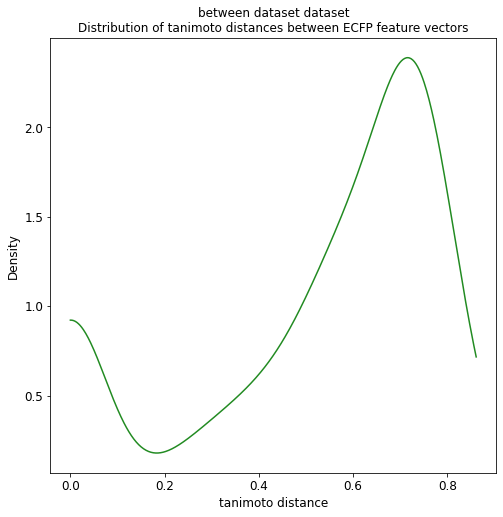

In [21]:
from scipy.stats.kde import gaussian_kde

import numpy as np
import matplotlib.pyplot as plt

odir='./'
task_name='between dataset'
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [22]:
!date


Fri Sep 17 13:15:33 UTC 2021
